## Lending Club Interest Rate Prediction

- Description
 - This data set represents thousands of loans made through the Lending Club platform, which is a platform that allows individuals to lend to other individuals. Of course, not all loans are created equal. Someone who is a essentially a sure bet to pay back a loan will have an easier time getting a loan with a low interest rate than someone who appears to be riskier. And for people who are very risky? They may not even get a loan offer, or they may not have accepted the loan offer due to a high interest rate. It is important to keep that last part in mind, since this data set only represents loans actually made, i.e. do not mistake this data for loan applications!

- Source
 - This data comes from Lending Club (https://www.lendingclub.com/info/statistics.action), which provides a very large, open set of data on the people who received loans through their platform.

## Walk-through of the Project
- 1. Cleansing, Preprocessing and EDA
    - Look at missing values
    - Distribution of interes rate
    - Categorical Variables
        -Explore categorical variables and interest rate
    - Numerical Variables
        -Explore numerical variables and interest rate
- 2. Feature engineering 
    - Adding more variables
    - Scaling & Getting dummy
    - Feature selection(Lasso CV)
- 3. Model 
    - Random Forest
    - XGBoost

## Import data

In [155]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from string import ascii_letters
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error,r2_score
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.preprocessing import Normalizer
from sklearn.model_selection import train_test_split
%matplotlib inline

In [2]:
data=pd.read_csv("loans_full_schema.csv")

In [3]:
data.head()

,emp_title,emp_length,state,homeownership,annual_income,verified_income,debt_to_income,annual_income_joint,verification_income_joint,debt_to_income_joint,...,sub_grade,issue_month,loan_status,initial_listing_status,disbursement_method,balance,paid_total,paid_principal,paid_interest,paid_late_fees
0,global config engineer,3.0,NJ,MORTGAGE,90000.0,Verified,18.01,NaN,NaN,NaN,...,C3,Mar-2018,Current,whole,Cash,27015.86,1999.33,984.14,1015.19,0.0
1,warehouse office clerk,10.0,HI,RENT,40000.0,Not Verified,5.04,NaN,NaN,NaN,...,C1,Feb-2018,Current,whole,Cash,4651.37,499.12,348.63,150.49,0.0
2,assembly,3.0,WI,RENT,40000.0,Source Verified,21.15,NaN,NaN,NaN,...,D1,Feb-2018,Current,fractional,Cash,1824.63,281.80,175.37,106.43,0.0
3,customer service,1.0,PA,RENT,30000.0,Not Verified,10.16,NaN,NaN,NaN,...,A3,Jan-2018,Current,whole,Cash,18853.26,3312.89,2746.74,566.15,0.0
4,security supervisor,10.0,CA,RENT,35000.0,Verified,57.96,57000.0,Verified,37.66,...,C3,Mar-2018,Current,whole,Cash,21430.15,2324.65,1569.85,754.80,0.0


## Cleansing, Preprocessing and EDA

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 55 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   emp_title                         9167 non-null   object 
 1   emp_length                        9183 non-null   float64
 2   state                             10000 non-null  object 
 3   homeownership                     10000 non-null  object 
 4   annual_income                     10000 non-null  float64
 5   verified_income                   10000 non-null  object 
 6   debt_to_income                    9976 non-null   float64
 7   annual_income_joint               1495 non-null   float64
 8   verification_income_joint         1455 non-null   object 
 9   debt_to_income_joint              1495 non-null   float64
 10  delinq_2y                         10000 non-null  int64  
 11  months_since_last_delinq          4342 non-null   float64
 12  earli

In [5]:
df_miss=data.isnull().sum()/len(data)*100
df_miss=pd.DataFrame(df_miss,columns=['percentage'])

Difficult for to fill in the null values because emp_title are categorical vairables.Too much category.Just delete this colum

In [6]:
##delete missing data>50%
df_miss[df_miss['percentage']>50]

,percentage
annual_income_joint,85.05
verification_income_joint,85.45
debt_to_income_joint,85.05
months_since_last_delinq,56.58
months_since_90d_late,77.15


In [7]:
##drop vairables missing values percentage>50
data_new=data.drop(df_miss[df_miss['percentage']>50].index,axis=1)

In [8]:
data_new.columns

Index(['emp_title', 'emp_length', 'state', 'homeownership', 'annual_income',
       'verified_income', 'debt_to_income', 'delinq_2y',
       'earliest_credit_line', 'inquiries_last_12m', 'total_credit_lines',
       'open_credit_lines', 'total_credit_limit', 'total_credit_utilized',
       'num_collections_last_12m', 'num_historical_failed_to_pay',
       'current_accounts_delinq', 'total_collection_amount_ever',
       'current_installment_accounts', 'accounts_opened_24m',
       'months_since_last_credit_inquiry', 'num_satisfactory_accounts',
       'num_accounts_120d_past_due', 'num_accounts_30d_past_due',
       'num_active_debit_accounts', 'total_debit_limit',
       'num_total_cc_accounts', 'num_open_cc_accounts',
       'num_cc_carrying_balance', 'num_mort_accounts',
       'account_never_delinq_percent', 'tax_liens', 'public_record_bankrupt',
       'loan_purpose', 'application_type', 'loan_amount', 'term',
       'interest_rate', 'installment', 'grade', 'sub_grade', 'issue_mon

### Dealing with categorical variables

In [9]:
cat_cols = data_new.select_dtypes(include=("object"))

In [10]:
cat_cols.columns

Index(['emp_title', 'state', 'homeownership', 'verified_income',
       'loan_purpose', 'application_type', 'grade', 'sub_grade', 'issue_month',
       'loan_status', 'initial_listing_status', 'disbursement_method'],
      dtype='object')

In [11]:
cat_cols['emp_title'].nunique()

4741

In [12]:
cat_cols['state'].nunique()

50

In [13]:
cat_cols['emp_title'].value_counts()

manager                               218
owner                                 204
teacher                               201
driver                                123
sales                                  97
                                     ... 
cooler service technician               1
its5                                    1
nursing supervisor                      1
partner physician                       1
brand ambassador/promotional model      1
Name: emp_title, Length: 4741, dtype: int64

In [14]:
## Too many unique values for employment title, which is low
cat_cols=cat_cols.drop(['emp_title'],axis=1)

In [15]:
for i in cat_cols.columns.tolist():
    print(data_new[i].value_counts())

CA    1330
TX     806
NY     793
FL     732
IL     382
NJ     338
OH     338
GA     334
NC     299
PA     298
VA     261
AZ     255
MD     247
MI     245
MA     237
WA     235
CO     235
CT     181
IN     178
TN     167
MO     159
MN     159
NV     158
SC     145
OR     130
WI     128
AL     122
KY      97
LA      96
KS      89
OK      81
MS      72
AR      70
WV      68
UT      61
NE      56
RI      53
NH      47
NM      43
ID      38
HI      35
AK      33
ME      26
MT      24
DE      24
VT      23
SD      20
WY      19
DC      19
ND      14
Name: state, dtype: int64
MORTGAGE    4789
RENT        3858
OWN         1353
Name: homeownership, dtype: int64
Source Verified    4116
Not Verified       3594
Verified           2290
Name: verified_income, dtype: int64
debt_consolidation    5144
credit_card           2249
other                  914
home_improvement       680
major_purchase         303
medical                162
house                  151
car                    131
small_business 

In [16]:
from scipy.stats import spearmanr

In [17]:
## Not much correlaiton between state and interest rate
data_new['state'].corr(data_new['interest_rate'],method='spearman')

0.0011210910173769094

In [18]:
cat_cols=cat_cols.drop(['state'],axis=1)

the correlation is not strong and delete the state columns

In [19]:
for i in cat_cols.columns.tolist():
    cor=data_new[i].corr(data_new['interest_rate'],method='spearman')
    print(i,cor)

homeownership 0.08748952903152749
verified_income 0.24571897146283708
loan_purpose 0.0476652973560531
application_type 0.053857860348730205
grade 0.9666157034979389
sub_grade 0.9981746241279144
issue_month -0.03445875962956296
loan_status 0.08271675152667414
initial_listing_status -0.10904837269519452
disbursement_method -0.18045601139148257


In [222]:
for i in cat_cols.columns.tolist():
    cor=data_new[i].corr(data_new['grade'],method='spearman')
    print(i,cor)

homeownership 0.07812752527000763
verified_income 0.23479181403496524
loan_purpose 0.05090817031653836
application_type 0.05495150790610031
grade 0.9999999999999999
sub_grade 0.968431774166524
issue_month -0.012100618280686318
loan_status 0.07546741175826262
initial_listing_status -0.11377718580877846
disbursement_method -0.17106527952418277


In [21]:
data_new['interest_rate'].round().value_counts()

10.0    1178
14.0    1073
7.0     1072
9.0      647
12.0     631
13.0     597
11.0     581
15.0     503
8.0      485
6.0      482
16.0     480
5.0      422
18.0     322
17.0     319
19.0     311
20.0     230
21.0     172
26.0     126
22.0      90
25.0      73
24.0      57
23.0      41
27.0      38
29.0      31
31.0      21
30.0      18
Name: interest_rate, dtype: int64

### Distribution of interest rate

/Users/yanzhenlei/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


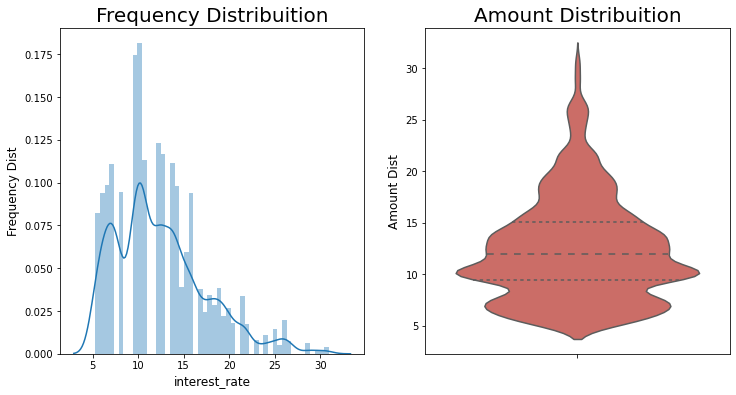

In [22]:
plt.figure(figsize=(12,6))
plt.subplot(121)
g = sns.distplot(data_new["interest_rate"])
g.set_xlabel("interest_rate", fontsize=12)
g.set_ylabel("Frequency Dist", fontsize=12)
g.set_title("Frequency Distribuition", fontsize=20)
plt.subplot(122)
g1 = sns.violinplot(y="interest_rate", data=data_new, 
               inner="quartile", palette="hls")
g1.set_xlabel("", fontsize=12)
g1.set_ylabel("Amount Dist", fontsize=12)
g1.set_title("Amount Distribuition", fontsize=20)

plt.show()

/Users/yanzhenlei/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


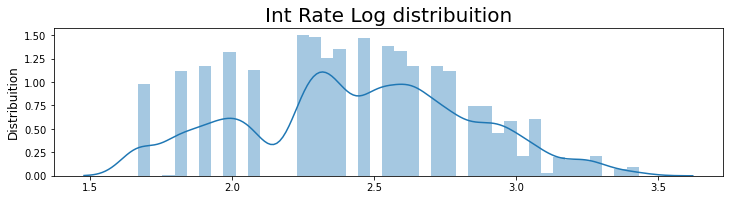

In [24]:
## The distribution of interest rate is right-skewed, we should log transfrom the interest rate
#Exploring the Int_rate
data_new['log_int_rate']=np.log(data_new["interest_rate"])
plt.figure(figsize=(12,6))
plt.subplot(211)
g = sns.distplot(data_new['log_int_rate'])
g.set_xlabel("", fontsize=12)
g.set_ylabel("Distribuition", fontsize=12)
g.set_title("Int Rate Log distribuition", fontsize=20)
plt.show()

If we are transform the distribution of interest rate, we can apply linear regression

###  Explore categorical variables and interest rate

### Grades and Subgrades

<AxesSubplot:xlabel='sub_grade', ylabel='interest_rate'>

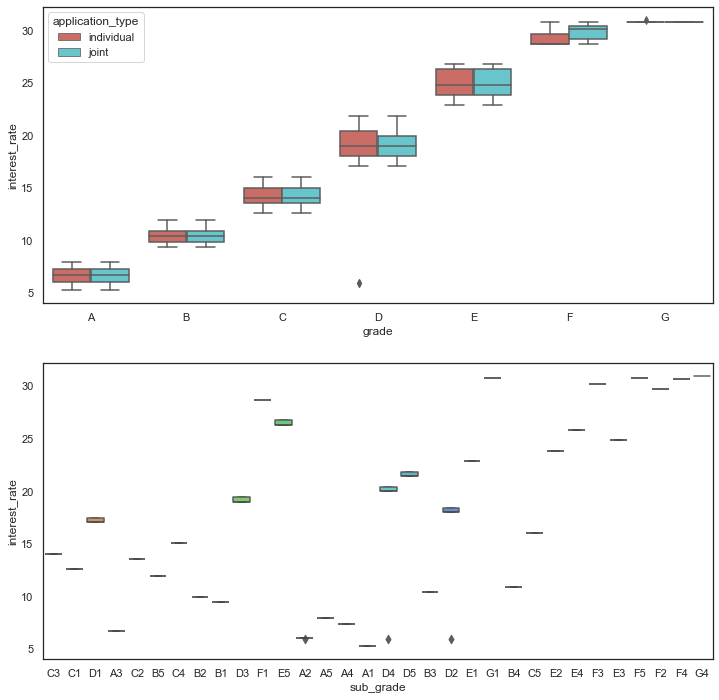

In [96]:
##Grade& interest rate
plt.figure(figsize=(12,12))
plt.subplot(211)
sns.boxplot(x="grade", y="interest_rate", data=data_new,palette="hls", hue="application_type", order=["A",'B','C','D','E','F', 'G'])
plt.subplot(212)
sns.boxenplot(x="sub_grade", y="interest_rate", data=data_new,palette="hls")

It is obvious that grade had high correlation with interest rate
Higher grade, higher interest rate

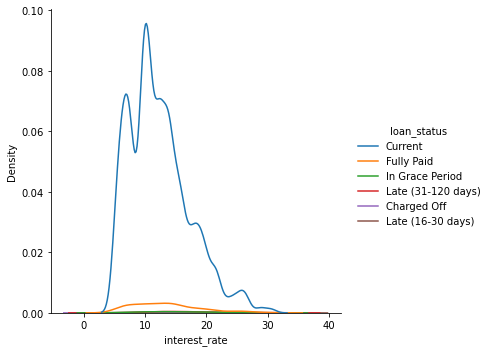

In [25]:
##Loan_status& interest rate
sns.displot(data=data_new,x="interest_rate",hue='loan_status',kind='kde')

In [28]:
##Homeownership& interest rate
data_new['homeownership'].value_counts()

MORTGAGE    4789
RENT        3858
OWN         1353
Name: homeownership, dtype: int64

In [30]:
data_new['homeownership_rent']=np.where(data_new['homeownership']=='RENT',1,0)

<AxesSubplot:xlabel='homeownership_rent', ylabel='interest_rate'>

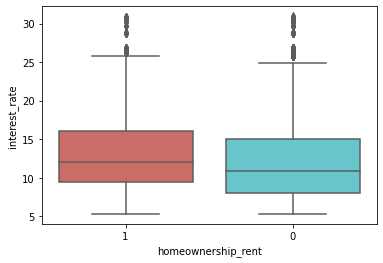

In [33]:
fig= plt.figsize=(24,10)
sns.boxplot(x="homeownership_rent", y="interest_rate", data=data_new,palette="hls",order=[1,0])

In [34]:
##Homeownership& interest rate
data_new['verified_income'].value_counts()

Source Verified    4116
Not Verified       3594
Verified           2290
Name: verified_income, dtype: int64

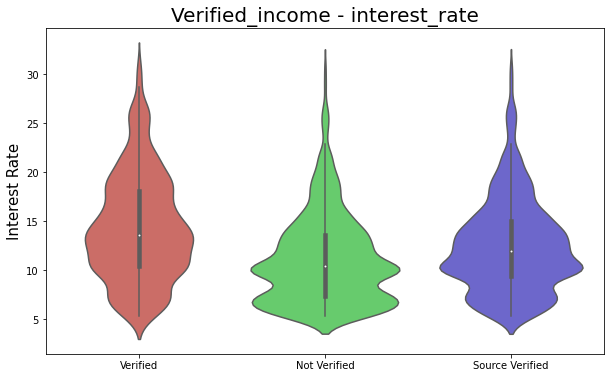

In [35]:
plt.figure(figsize = (10,6))

g = sns.violinplot(x="verified_income",y="interest_rate",data=data_new,
               kind="violin",
               split=True,palette="hls")
g.set_title("Verified_income - interest_rate", fontsize=20)
g.set_xlabel("", fontsize=15)
g.set_ylabel("Interest Rate", fontsize=15)

plt.show()

higher correlation with grade, maintain the columns

All categorical variables are bearable number of categories

In [72]:
df_cat = pd.get_dummies(cat_cols,columns=cat_cols.columns.tolist(),drop_first=True)

df_cat

## Numerical columns processing

In [39]:
# Subset numeric features: numeric_cols
numeric_cols = data_new.select_dtypes(include=[np.number])
# Iteratively impute
imp_iter = IterativeImputer(max_iter=5, sample_posterior=True, random_state=123)
loans_imp_iter = imp_iter.fit_transform(numeric_cols)
# Convert returned array to DataFrame
loans_imp_iterDF = pd.DataFrame(loans_imp_iter, columns=numeric_cols.columns)

In [40]:
numeric_cols.columns

Index(['emp_length', 'annual_income', 'debt_to_income', 'delinq_2y',
       'earliest_credit_line', 'inquiries_last_12m', 'total_credit_lines',
       'open_credit_lines', 'total_credit_limit', 'total_credit_utilized',
       'num_collections_last_12m', 'num_historical_failed_to_pay',
       'current_accounts_delinq', 'total_collection_amount_ever',
       'current_installment_accounts', 'accounts_opened_24m',
       'months_since_last_credit_inquiry', 'num_satisfactory_accounts',
       'num_accounts_120d_past_due', 'num_accounts_30d_past_due',
       'num_active_debit_accounts', 'total_debit_limit',
       'num_total_cc_accounts', 'num_open_cc_accounts',
       'num_cc_carrying_balance', 'num_mort_accounts',
       'account_never_delinq_percent', 'tax_liens', 'public_record_bankrupt',
       'loan_amount', 'term', 'interest_rate', 'installment', 'balance',
       'paid_total', 'paid_principal', 'paid_interest', 'paid_late_fees',
       'log_int_rate', 'homeownership_rent'],
      dty

<AxesSubplot:>

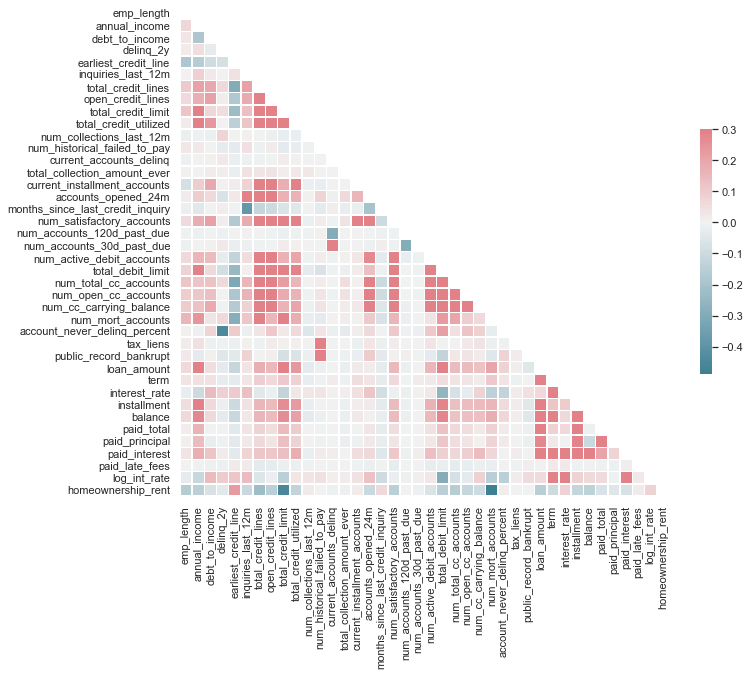

In [41]:
##correlations
sns.set(style="white")

corr = loans_imp_iterDF.corr()

mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

f, ax = plt.subplots(figsize=(11, 9))

cmap = sns.diverging_palette(220, 10, as_cmap=True)

sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [81]:
X_num=loans_imp_iterDF.drop(['interest_rate'],axis=1)
for i in X_num.columns.tolist():
    cor=loans_imp_iterDF[i].corr(loans_imp_iterDF['interest_rate'])
    print(i,cor)

emp_length -0.022864260617945827
annual_income -0.09958433559316995
debt_to_income 0.14013187435197783
delinq_2y 0.09045622123463228
earliest_credit_line 0.10363461600403122
inquiries_last_12m 0.13119296831174532
total_credit_lines -0.04443485546943214
open_credit_lines -0.012773330697410155
total_credit_limit -0.1304965801657026
total_credit_utilized 0.03152743152587917
num_collections_last_12m 0.02990136827787591
num_historical_failed_to_pay 0.03756269731790593
current_accounts_delinq 0.007184083055156142
total_collection_amount_ever 0.013532163648097315
current_installment_accounts 0.047131258024430724
accounts_opened_24m 0.120656747256795
months_since_last_credit_inquiry -0.08684992876486065
num_satisfactory_accounts -0.013329575570643909
num_accounts_120d_past_due -0.012513901637688854
num_accounts_30d_past_due 0.007184083055156142
num_active_debit_accounts 0.0268002604908547
total_debit_limit -0.254225259596709
num_total_cc_accounts -0.07123798773636468
num_open_cc_accounts -0.02

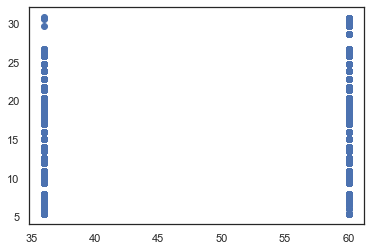

In [43]:
plt.plot(data_new['term'],data_new['interest_rate'],'bo')
plt.show()

In [45]:
data_new['term_36']=data_new['term'][data_new['term']==36]
data_new['term_60']=data_new['term'][data_new['term']==60]

In [46]:
data_new['term_36']=np.where(data_new['term_36']==36,1,0)
data_new['term_60']=np.where(data_new['term_60']==60,1,0)

In [47]:
loans_imp_iterDF=loans_imp_iterDF.drop(['term'],axis=1)

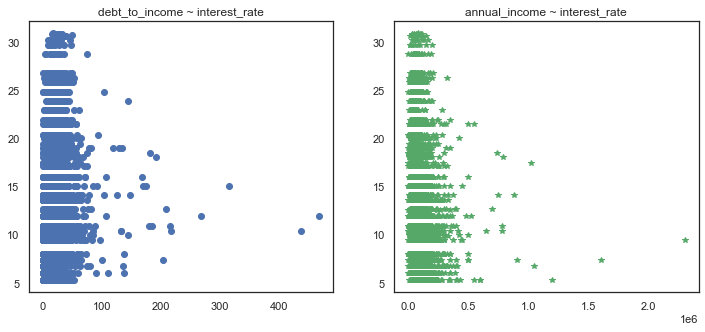

In [221]:
plt.figure(figsize=(12,5))
plt.subplot(121)
plt.plot(data_new['debt_to_income'],data_new['interest_rate'],'bo')
plt.title('debt_to_income ~ interest_rate')
plt.subplot(122)
plt.plot(data_new['annual_income'],data_new['interest_rate'],'g*')
plt.title('annual_income ~ interest_rate')
plt.show()

In [82]:
df_for_RF=pd.concat([df_cat,loans_imp_iterDF],axis=1)

In [83]:
len(df_for_RF.columns)

101

In [84]:
df_total['log_int_rate'].isnull().sum()

0

df_total.to_csv('df_total.csv')

## DATA Scaling

In [127]:
#normalise the data
X_train, y_train = Train.drop(['log_int_rate','interest_rate'], axis=1), Train.interest_rate
X_test, y_test = Test.drop(['log_int_rate','interest_rate'], axis=1), Test.interest_rate
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
df_for_RF=pd.merge(X_train,)

## Feature selection
Too much variables for 10000 samples

In [ ]:
df_for_RF

In [90]:
from sklearn.ensemble import RandomForestClassifier

In [101]:
df_for_RF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Columns: 101 entries, homeownership_OWN to homeownership_rent
dtypes: float64(39), uint8(62)
memory usage: 3.6 MB


In [109]:
size = df_for_RF.shape[0]

Train, Test_new = train_test_split(df_for_RF, test_size= 0.3, random_state= 1)

CV, Test_new = train_test_split(Test_new, test_size=0.5, random_state = 1)

print(Train.shape, CV.shape, Test_new.shape)

(7000, 101) (1500, 101) (1500, 101)


In [115]:
CV

,homeownership_OWN,homeownership_RENT,verified_income_Source Verified,verified_income_Verified,loan_purpose_credit_card,loan_purpose_debt_consolidation,loan_purpose_home_improvement,loan_purpose_house,loan_purpose_major_purchase,loan_purpose_medical,...,loan_amount,interest_rate,installment,balance,paid_total,paid_principal,paid_interest,paid_late_fees,log_int_rate,homeownership_rent
4940,0,0,1,0,0,1,0,0,0,0,...,20000.0,5.32,602.30,17932.68,2403.29,2067.32,335.97,0.0,1.671473,0.0
7276,0,0,0,1,1,0,0,0,0,0,...,20000.0,15.04,693.70,18654.17,2064.39,1345.83,718.56,0.0,2.710713,0.0
7829,0,0,1,0,1,0,0,0,0,0,...,35000.0,16.01,851.32,33831.46,2522.83,1168.54,1354.29,0.0,2.773214,0.0
9466,1,0,1,0,1,0,0,0,0,0,...,5000.0,11.98,166.03,4766.61,325.40,233.39,92.01,0.0,2.483239,0.0
8477,0,0,0,0,1,0,0,0,0,0,...,20000.0,7.34,620.66,18495.86,1853.82,1504.14,349.68,0.0,1.993339,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
401,0,0,1,0,0,1,0,0,0,0,...,30000.0,9.43,960.01,27810.09,2887.90,2189.91,697.99,0.0,2.243896,0.0
6899,0,0,0,0,0,0,0,0,0,1,...,10000.0,9.93,322.35,8782.01,1597.96,1217.99,379.97,0.0,2.295560,0.0
5938,0,1,1,0,0,1,0,0,0,0,...,11000.0,21.45,300.38,10573.72,1168.75,426.28,742.47,0.0,3.065725,1.0
3632,0,0,0,0,0,1,0,0,0,0,...,10000.0,10.42,324.65,8759.13,1566.21,1240.87,325.34,0.0,2.343727,0.0


In [133]:
X_train, y_train = Train.drop(['log_int_rate','interest_rate'], axis=1), Train.interest_rate
X_test, y_test = Test_new.drop(['log_int_rate','interest_rate'], axis=1), Test.interest_rate
CV_x,CV_y= CV.drop(['log_int_rate','interest_rate'], axis=1), CV.interest_rate
x_col=X_train.columns

In [134]:
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
CV_x=scaler.transform(CV_x)

In [135]:
Test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1500 entries, 5309 to 5509
Columns: 101 entries, homeownership_OWN to homeownership_rent
dtypes: float64(39), uint8(62)
memory usage: 559.6 KB


In [136]:
CV_x

array([[-0.39384707, -0.79743102,  1.19570561, ..., -0.50967092,
        -0.06058442, -0.79743102],
       [-0.39384707, -0.79743102, -0.83632626, ...,  0.22273732,
        -0.06058442, -0.79743102],
       [-0.39384707, -0.79743102,  1.19570561, ...,  1.4397422 ,
        -0.06058442, -0.79743102],
       ...,
       [-0.39384707,  1.25402696,  1.19570561, ...,  0.26850925,
        -0.06058442,  1.25402696],
       [-0.39384707, -0.79743102, -0.83632626, ..., -0.53002038,
        -0.06058442, -0.79743102],
       [-0.39384707, -0.79743102, -0.83632626, ..., -0.75516619,
        -0.06058442, -0.79743102]])

In [137]:
from sklearn.linear_model import LassoCV

/Users/yanzhenlei/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 47.482425143210094, tolerance: 13.976402134792863
  model = cd_fast.enet_coordinate_descent_gram(
/Users/yanzhenlei/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 47.74899457664486, tolerance: 14.105763850998242
  model = cd_fast.enet_coordinate_descent_gram(
/Users/yanzhenlei/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 48.38152692615847, tolerance: 14.244188974555362
  model = cd_fast.enet_coordinate_descent_gram(
/Users/yanzhenlei/opt/anaconda3/lib/pyt

RMSE of Lasso:  0.3729692584224117


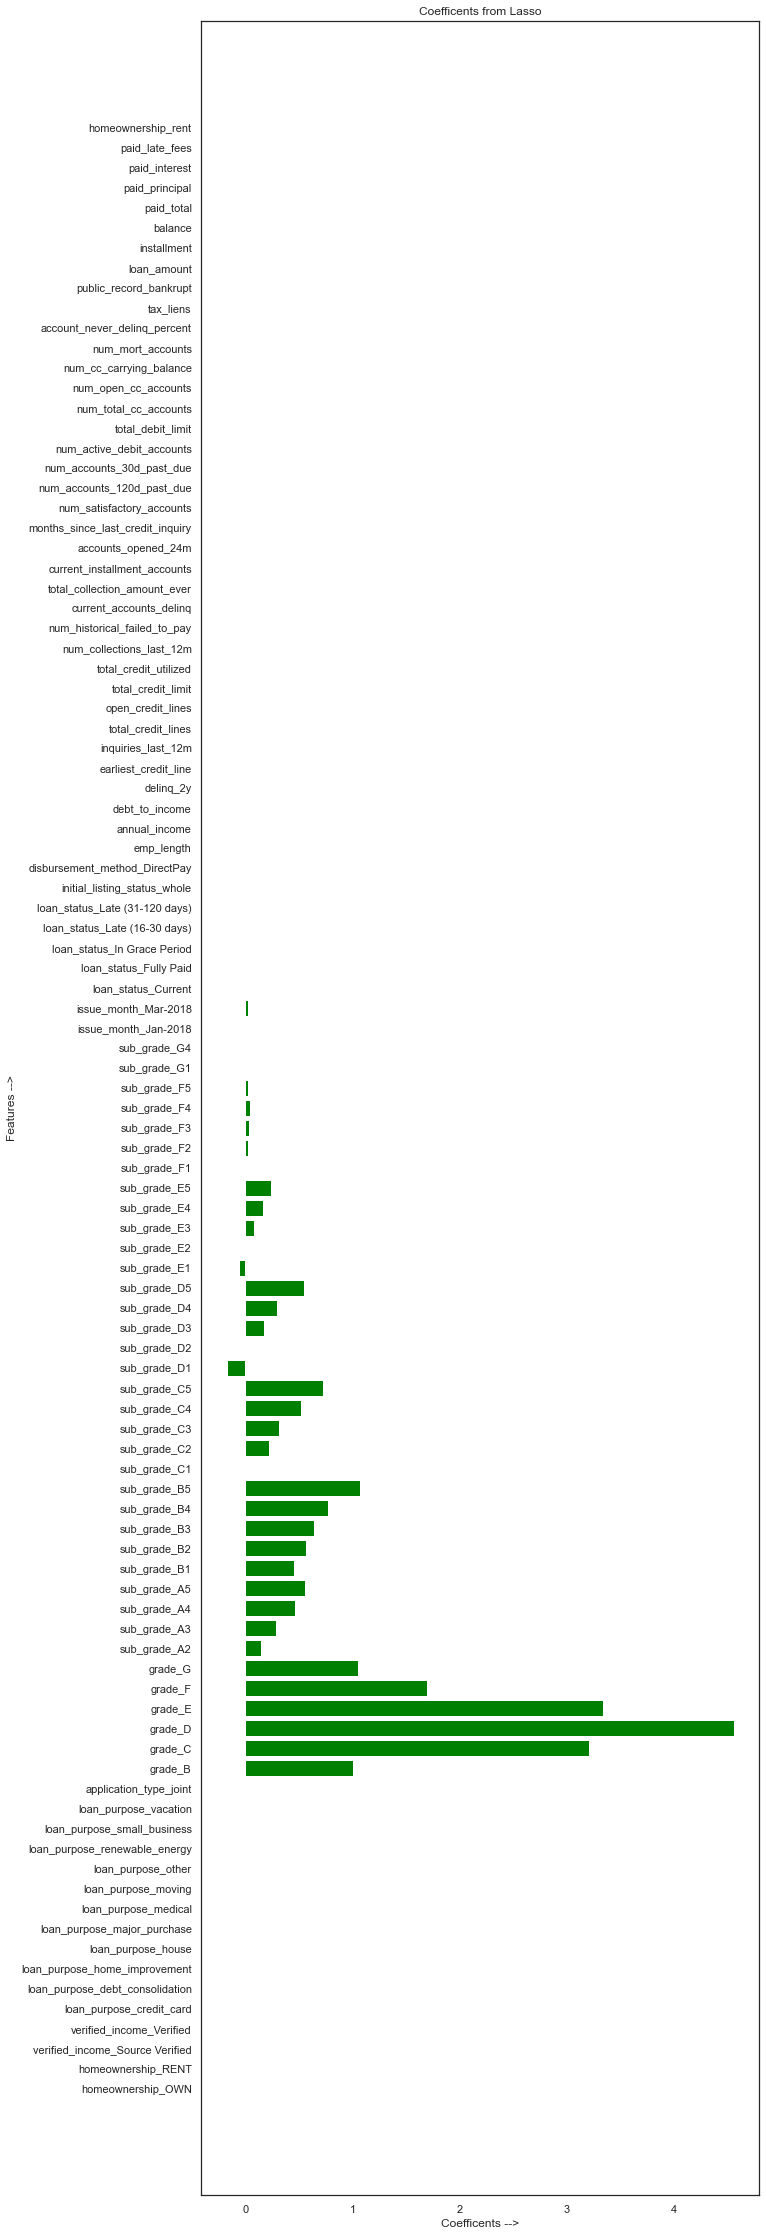

In [140]:
modellasso = LassoCV(alphas = [1, 0.1, 0.001, 0.0001, 10, 1000]).fit(X_train,y_train)
lassopred = modellasso.predict(CV_x)
print("RMSE of Lasso: ", np.sqrt(mean_squared_error(lassopred, CV_y)))

coeff = modellasso.coef_

x = list(x_col)
x_pos = [i for i, _ in enumerate(x)]


plt.figure(figsize = (10,40))
plt.barh(x_pos, coeff, color='green')
plt.ylabel("Features -->")
plt.xlabel("Coefficents -->")
plt.title("Coefficents from Lasso")
plt.yticks(x_pos, x)

plt.show()

In [142]:
data_col=pd.DataFrame(columns=['name','coeff'])
co=list(coeff)

In [143]:
data_col['name']=x_col
data_col['coeff']=co

In [144]:
data_col.sort_values(by='coeff',ascending=False)

,name,coeff
18,grade_D,4.557579
19,grade_E,3.333528
17,grade_C,3.205376
20,grade_F,1.692306
30,sub_grade_B5,1.067477
...,...,...
53,issue_month_Jan-2018,-0.004499
68,total_credit_lines,-0.005607
31,sub_grade_C1,-0.005758
41,sub_grade_E1,-0.062488


In [145]:
data_col.count()

name     99
coeff    99
dtype: int64

In [183]:
col=data_col[abs(data_col['coeff'])>0.5]

In [184]:
col.count()

name     14
coeff    14
dtype: int64

In [185]:
col['name'].tolist()

['grade_B',
 'grade_C',
 'grade_D',
 'grade_E',
 'grade_F',
 'grade_G',
 'sub_grade_A5',
 'sub_grade_B2',
 'sub_grade_B3',
 'sub_grade_B4',
 'sub_grade_B5',
 'sub_grade_C4',
 'sub_grade_C5',
 'sub_grade_D5']

## Random Forest
- Advantages of random forest
    - It can perform both regression and classification tasks.
    - A random forest produces good predictions that can be understood easily.
    - It can handle large datasets efficiently.
    - The random forest algorithm provides a higher level of accuracy in predicting outcomes over the decision tree algorithm.
- Disadvantages of random forest
    - When using a random forest, more resources are required for computation.
    - It consumes more time compared to a decision tree algorithm.

In [186]:
features= df_for_RF[col['name'].tolist()]
labels=df_total['interest_rate']

In [187]:
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size = 0.3,random_state = 42)

In [188]:
print('Training Features Shape:', train_features.shape)
print('Testing Features Shape:', test_features.shape)
print('Training Labels Shape:', train_labels.shape)
print('Testing Labels Shape:', test_labels.shape)

Training Features Shape: (7000, 14)
Testing Features Shape: (3000, 14)
Training Labels Shape: (7000,)
Testing Labels Shape: (3000,)


In [189]:
from sklearn.ensemble import RandomForestRegressor

In [209]:
# Instantiate model (Using Default 10 Estimators)
rf = RandomForestRegressor(n_estimators= 10, random_state=42)

# Using Evaluation Function on our First Model

rf.fit(train_features, train_labels)

y_test_pred = rf.predict(test_features)

In [210]:
y_test_pred.shape

(3000,)

In [211]:
# Mean squared error
from sklearn import metrics
print("Mean squared error: %.2f" % mean_squared_error(test_labels, y_test_pred))
print('Mean Absolute Percentage Error (MAPE):', round(metrics.mean_absolute_percentage_error(test_labels, y_test_pred) * 100, 2))
print('Accuracy:', round(100*(1 - metrics.mean_absolute_percentage_error(test_labels, y_test_pred)), 2))

Mean squared error: 0.36
Mean Absolute Percentage Error (MAPE): 3.55
Accuracy: 96.45


## Randomforest tuning
For model performance improvement, We should use parameter tunning
- n_estimators
  - The n_estimators parameter specifies the number of trees in the forest of the model. The default value for this parameter is 10, which means that 10 different decision trees will be constructed in the random forest.
- max_depth 
  - The max_depth parameter specifies the maximum depth of each tree. The default value for max_depth is None, which means that each tree will expand until every leaf is pure. A pure leaf is one where all of the data on the leaf comes from the same class.
- min_samples_split
   - The min_samples_split parameter specifies the minimum number of samples required to split an internal leaf node. The default value for this parameter is 2, which means that an internal node must have at least two samples before it can be split to have a more specific classification.
- min_samples_leaf
   - The min_samples_leaf parameter specifies the minimum number of samples required to be at a leaf node. The default value for this parameter is 1, which means that every leaf must have at least 1 sample that it classifies.

*
param_test1 = {'n_estimators':range(10,71,10),
              {'max_depth':range(3,14,2),
              'min_samples_split':range(50,201,20),
              'min_samples_leaf':range(30,60,10)
              }
gsearch1 = GridSearchCV(estimator = RandomForestClassifier(min_samples_split=100
min_samples_leaf=20,max_depth=8,max_features='
param_grid = param_test1, scoring='roc_auc',cv=5)
gsearch1.fit(X,y)
gsearch1.best_params_, gsearch1.best_score_
*

## XGBoost
XGBoost is a highly optimized framework for gradient boosting, an algorithm that iteratively combines the predictions of several weak learners such as decision trees to produce a much stronger and more robust model.

In [193]:
from scipy import stats 
from sklearn.metrics import (
    accuracy_score, confusion_matrix, classification_report, 
    roc_auc_score, roc_curve, auc,
    plot_confusion_matrix, plot_roc_curve
)
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from xgboost import XGBClassifier

param_grid = dict(
    n_estimators=stats.randint(10, 500),
    max_depth=stats.randint(1, 10),
    learning_rate=stats.uniform(0, 1)
    )

xgb_clf = XGBClassifier()
xgb_cv = RandomizedSearchCV(
    xgb_clf, param_grid, cv=3, n_iter=60, 
    scoring='roc_auc', n_jobs=-1, verbose=1)
xgb_cv.fit(X_train, y_train)

best_params = xgb_cv.best_params_
print(best_params)

In [175]:
best_params['booster'] = 'gblinear'
print(f"Best Parameters: {best_params}")

Best Parameters: {'learning_rate': 0.0012592383320760847, 'max_depth': 8, 'n_estimators': 204, 'booster': 'gblinear'}


In [212]:
xgb_clf = XGBClassifier({'learning_rate': 0.0012592383320760847, 'max_depth': 8, 'n_estimators': 204, 'booster': 'gblinear'})


xgb_clf.fit(train_features, train_labels)

y_test_pred = xgb_clf.predict(test_features)

/Users/yanzhenlei/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py:416: FutureWarning: Pass `objective` as keyword args.  Passing these as positional arguments will be considered as error in future releases.
  warnings.warn(
/Users/yanzhenlei/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:54:39] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [213]:
print("Mean squared error: %.2f" % mean_squared_error(test_labels, y_test_pred))
print('Mean Absolute Percentage Error (MAPE):', round(metrics.mean_absolute_percentage_error(test_labels, y_test_pred) * 100, 2))
print('Accuracy:', round(100*(1 - metrics.mean_absolute_percentage_error(test_labels, y_test_pred)), 2))

Mean squared error: 0.62
Mean Absolute Percentage Error (MAPE): 4.64
Accuracy: 95.36


In [204]:
# define model evaluation method
cv = RepeatedKFold(n_splits=5, n_repeats=3, random_state=1)
# evaluate model
scores = cross_val_score(xgb_clf, train_features, train_labels, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
print('Mean MAE: %.3f (%.3f)' % (scores.mean(), scores.std()) )

Mean MAE: -0.491 (0.042)


In [203]:
# define model evaluation method
cv = RepeatedKFold(n_splits=5, n_repeats=3, random_state=1)
# evaluate model
scores = cross_val_score(rf, train_features, train_labels, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
print('Mean MAE: %.3f (%.3f)' % (scores.mean(), scores.std()) )

Mean MAE: -0.383 (0.015)


## Conclusion


- Model Selection
    - Randomforest Model has mean MAE-0.383 and MAPE 3.55
    - XGBoost Model has mean MAE -0.491 and MAPE 4.64
    - Randomforest would be a better choice
- Feature Selection
    - The feature I choose are basily about Grade and Subgrade
        -grade: Grade associated with the loan.
        -sub_grade: Detailed grade associated with the loan.
    - However, we don't know what does grade are given. Only when we find out what influence grades, we can deep dive into different variables that affecting interest rate.
- Next step:
    - Add more models(Neural Networks and Linear regression)
    - Explore more about how does grades and sub-grades influences the interest rate. Correlaiton does not mean causual inferences
    - Explore more on the parameters,optimizing the performance of the model